# "Attention is All You Need" in Pytorch

Attention is all you need paper: https://arxiv.org/pdf/1706.03762.pdf

"We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million
sentence pairs. Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget vocabulary of about 37000 tokens."


Data was downloaded manually from https://nlp.stanford.edu/projects/nmt/ since torchnlp seems to be broken

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from collections import OrderedDict
from functools import partial
import importlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
from src import data
from src import torch_models as models
from src import train_utils
import src.utils as utils

# reload during active development
importlib.reload(data)
importlib.reload(models)

<module 'src.torch_models' from '/mnt/ml_implementations/torch/attention/src/torch_models.py'>

In [4]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Train tokenizer using BBPE

"Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget vocabulary of about 37000 tokens"

Use tokenizers from huggingface

In [5]:
train_path_en = 'data/train.en'
train_path_de = 'data/train.de'
tokenizer_path = "data/tokenizer-bbpe-joint.json"

In [6]:
bbpe = data.get_bbpe_tokenizer(tokenizer_path, data_file_list=[train_path_en, train_path_de])

INFO:root:loading BBPE tokenizer at data/tokenizer-bbpe-joint.json


In [7]:
encoding = bbpe.encode(
    'this is a test sentence for byte pair encoding outofvocabword')
print(encoding.ids)
bbpe.decode(encoding.ids)

[3120, 336, 1818, 267, 21573, 277, 3099, 1019, 1203, 4027, 286, 10936, 316, 22466, 1014, 512, 6690, 9969, 85, 2143, 536, 24299]


'this is a test sentence for byte pair encoding outofvocabword'

In [8]:
encoding = bbpe.encode(
    'Dies ist ein Testsatz für die Bytepaar-Kodierung von outofvocabword')
print(encoding.ids)
bbpe.decode(encoding.ids)

[1131, 362, 289, 3509, 1077, 369, 272, 14607, 286, 27719, 12, 42, 1014, 661, 344, 6690, 9969, 85, 2143, 536, 24299]


'Dies ist ein Testsatz für die Bytepaar-Kodierung von outofvocabword'

## Build Model

In [9]:
importlib.reload(models)
importlib.reload(train_utils)
max_seqlen = 64
model_config = models.ModelConfig(
    dim=512,
    N=2,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_seqlen,
    drop_rate=0.01,
    position_encoding_class=models.LearnablePositionalEncoding,
)

In [11]:
seqlen = 22
tokens = [1] * seqlen
tokens = torch.tensor(tokens).unsqueeze(0)

### Attn is all you need encoder-decoder

In [77]:
importlib.reload(models)
model_encdec = models.AttnIsAllYouNeed.from_config(model_config)

_ = model_encdec.apply(train_utils.init_ones)
model_encdec(tokens, tokens)

tensor([[[456.4881, 456.4881, 456.4881,  ..., 456.4870, 456.4870, 456.4870],
         [379.1380, 379.1380, 379.1380,  ..., 379.1373, 379.1373, 379.1373],
         [729.3707, 729.3707, 729.3707,  ..., 729.3685, 729.3685, 729.3685],
         ...,
         [354.6602, 354.6602, 354.6602,  ..., 354.6608, 354.6608, 354.6608],
         [985.1044, 985.1044, 985.1044,  ..., 985.1044, 985.1044, 985.1044],
         [360.9518, 360.9518, 360.9518,  ..., 360.9523, 360.9523, 360.9523]]],
       grad_fn=<AddBackward0>)

In [14]:
sum(p.numel() for p in model_encdec.parameters())

45489459

## Data Pipelines

In [13]:
if 'train_lines' not in locals():
    train_lines = sum(1 for line in open(data.TRAIN_PATH_EN, encoding='utf-8'))
if 'test_lines' not in locals():
    test_lines = sum(1 for line in open(data.TEST_PATH_DE, encoding='utf-8'))
print(f'train lines: {train_lines}')
print(f'test lines: {test_lines}')

train lines: 4468840
test lines: 2737


In [14]:
os.cpu_count()

48

### training/ data params

docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [106]:
importlib.reload(data)
dataset_config = data.DatasetConfig(bbpe, model_config.max_context)

# NB: add start token to German tokens (input into decoder stack)
# given start token and english sentence, we want the model to output the first german word
# Note lack of start token on target_fn
def input_fn(en_line, de_line, data_config):
    en_input = data.str_to_tok(en_line, data_config, add_start=False)
    de_input = data.str_to_tok(de_line, data_config, add_start=True)
    return (en_input, de_input)

def target_fn(en_line, de_line, data_config):
    return data.str_to_tok(de_line, data_config, add_start=False)
    
batch_size = 64

 Training would be more efficient with seqlen-aware batching, but for now a first order implementation is sufficient

In [107]:
# translation training
importlib.reload(data)
importlib.reload(train_utils)
importlib.reload(utils)

train_dataset = data.WMT2014Mixing(
    num_pools=7919,  # pick a prime number
    start_line=0,
    end_line=train_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=True,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
)

test_dataset = data.WMT2014Mixing(
    num_pools=101,  # pick a prime number
    start_line=0,
    end_line=test_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

INFO:root:Loading existing line breaks for file data/train.en at data/train.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/train.de at data/train.de_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 7919 pools with 564 lines per pool
INFO:root:Loading existing line breaks for file data/test/newstest2014.en at data/test/newstest2014.en_linebreaks.pickle
INFO:root:Loading existing line breaks for file data/test/newstest2014.de at data/test/newstest2014.de_linebreaks.pickle
INFO:root:IterShuffleMixin: Initializing 101 pools with 27 lines per pool


## Training

Paper uses:

- emb_dimension, attn_dimension = 512
- n_heads = 8
- p_drop = 0.1
- N = 6
- train steps 100k

We have less compute so need to scale down the model to fit on one GPU

In [69]:
loss_history_path = './saved_models/encdec_loss_histories.pickle'
if os.path.exists(loss_history_path):
    with open(loss_history_path, 'rb') as f:
        loss_histories = pickle.load(f)
else:
    loss_histories = dict()
loss_histories.keys()

dict_keys(['encdec_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'])

We need a custom function to call our model because it accepts two different inputs

In [109]:
def model_call(model, inputs):
    en = inputs[:,0,:]
    de_w_start_tok = inputs[:,1,:]
    return model(en, de_w_start_tok)

In [110]:
_ = model_encdec.apply(train_utils.min_gpt_init_weights)

Train toy model on 48xCPU as a sanity check

In [111]:
expt_key = 'encdec_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle'

In [118]:
importlib.reload(train_utils)
importlib.reload(data)

train_utils.train_epoch(
    model_encdec,
    loss_histories,
    expt_key,
    'cuda',
    train_loader,
    test_loader,
    dataset_config,
    model_call = model_call,
    eval_every=100000,
    save_every=100000,
    save_state_only=True,
)

INFO:root:saving models to ./saved_models/encdec_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle
  2%|▏         | 1563/69826 [09:14<46:28:33,  2.45s/it]

      100032: training loss 5.014059066772461, test loss 5.772504125322614


  4%|▍         | 3125/69826 [18:27<43:33:15,  2.35s/it]

      200000: training loss 4.997960567474365, test loss 5.556138753890991


  9%|▉         | 6250/69826 [36:53<42:38:01,  2.41s/it]

      400000: training loss 4.94189453125, test loss 5.314173017229352


 18%|█▊        | 12500/69826 [1:13:42<39:49:10,  2.50s/it]

      800000: training loss 4.444680690765381, test loss 5.056511844907488


 36%|███▌      | 25000/69826 [2:27:25<30:27:51,  2.45s/it]

     1600000: training loss 4.2262725830078125, test loss 4.805707170849755


 72%|███████▏  | 50000/69826 [4:53:34<16:30:20,  3.00s/it]

     3200000: training loss 4.076580047607422, test loss 4.60772601948228


100%|█████████▉| 69565/69826 [6:48:18<01:14,  3.50it/s]   


Final:      4452160: training loss 3.722892999649048, test loss 4.514776048206148


In [119]:
with open(loss_history_path, 'wb') as f:
    pickle.dump(loss_histories, f)

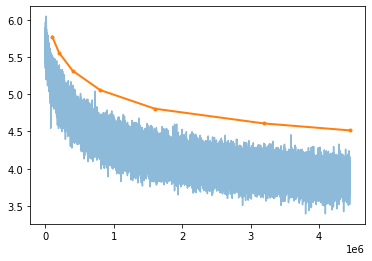

In [133]:
plt.plot(*zip(*loss_histories[expt_key]['train_loss']), alpha=.5)
plt.plot(*zip(*loss_histories[expt_key]['test_loss']), '.-', linewidth=2)